# Step 2 Dengue Nowcasting (Mixed-Lag ARX)

This notebook implements a Step 2 model of the form:

$x_t = \beta_0 + \beta_1 g_{t,1} + \beta_2 g_{t,2} + \text{month dummies} + \phi_1 \tilde{x}_{t-1} + \phi_2 \tilde{x}_{t-2}$

with mixed-lag input

$\tilde{x}_{t-k} = \begin{cases} y^{WHO}_{t-k}, & \text{if WHO available}\\ x^{(step1)}_{t-k}, & \text{otherwise}\end{cases}$

Inputs:
- `master_data.csv` (Monthly rows; columns: resolution, date, value, source)
- Step 1 monthly predictions CSV (default: `outputs_step1/predictions_step1_monthly.csv`)

Outputs (saved to `outputs_step2/` by default):
- `cv_metrics.csv`
- `nowcast_who.csv`
- `step2_coefficients.csv`
- plots (`who_vs_pred_step2.png`, `yearly_vs_opendengue_step2.png` if available, `step1_vs_step2_predictions.png`)


In [ ]:
# If needed, install dependencies in your environment:
# !pip install pandas numpy scikit-learn matplotlib


In [1]:
import os
from dataclasses import dataclass
from typing import Tuple

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

try:
    from sklearn.metrics import root_mean_squared_error  # scikit-learn >= 1.4
    _HAS_RMSE = True
except Exception:
    _HAS_RMSE = False


In [2]:
@dataclass
class Step2Config:
    # Inputs
    data_path: str = 'master_data.csv'
    step1_predictions_path: str = os.path.join('outputs_step1', 'predictions_step1_monthly.csv')
    step1_pred_col: str = 'x_pred'  # column in Step 1 CSV; if not found, the first '*pred*' column is used

    # Outputs
    outdir: str = 'outputs_step2'

    # Target/source names in master_data.csv
    target_source: str = 'WHO'

    # Exogenous signals g_{t,1}, g_{t,2}
    google_sources: Tuple[str, str] = (
        'Google_Trends_Dengue_fever',
        'Google_Trends_Dengue_vaccine',
    )

    # Feature engineering
    lags_y: Tuple[int, ...] = (1, 2)
    use_month_dummies: bool = True

    # Model (ElasticNet)
    alpha: float = 0.05
    l1_ratio: float = 0.3
    random_state: int = 42
    max_iter: int = 20000

    # Evaluation
    n_splits: int = 5
    test_horizon: int | None = None


cfg = Step2Config(
    # Edit these paths if your files are elsewhere
    data_path='master_data.csv',
    step1_predictions_path=os.path.join('outputs_step1', 'predictions_step1_monthly.csv'),
    outdir='outputs_step2',
)
cfg

Step2Config(data_path='master_data.csv', step1_predictions_path='outputs_step1/predictions_step1_monthly.csv', step1_pred_col='x_pred', outdir='outputs_step2', target_source='WHO', google_sources=('Google_Trends_Dengue_fever', 'Google_Trends_Dengue_vaccine'), lags_y=(1, 2), use_month_dummies=True, alpha=0.05, l1_ratio=0.3, random_state=42, max_iter=20000, n_splits=5, test_horizon=None)

In [3]:
def ensure_outdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def _parse_monthly_date_any(x: pd.Series) -> pd.Series:
    """Parse date column that may be 'YYYY-MM', 'YYYY-MM-01', or already a date."""
    s = x.astype(str)
    s2 = np.where(s.str.match(r'^\d{4}-\d{2}$'), s + '-01', s)
    return pd.to_datetime(s2, errors='coerce')


def load_monthly_wide_from_master(cfg: Step2Config) -> pd.DataFrame:
    df = pd.read_csv(cfg.data_path)
    need = {'resolution', 'date', 'value', 'source'}
    missing = need - set(df.columns)
    if missing:
        raise ValueError(f"{cfg.data_path} missing columns: {sorted(missing)}")

    df = df[df['resolution'].astype(str).str.lower().eq('monthly')].copy()
    df['date'] = _parse_monthly_date_any(df['date'])
    df = df.dropna(subset=['date']).copy()

    wide = (
        df.pivot_table(index='date', columns='source', values='value', aggfunc='mean')
        .sort_index()
    )
    return wide


def load_step1_predictions(cfg: Step2Config) -> pd.Series:
    if not os.path.exists(cfg.step1_predictions_path):
        raise FileNotFoundError(
            f"Step 1 predictions file not found: {cfg.step1_predictions_path}. "
            "Run Step 1 first to generate predictions_step1_monthly.csv."
        )

    s1 = pd.read_csv(cfg.step1_predictions_path)
    if 'date' not in s1.columns:
        raise ValueError(f"Step 1 predictions file missing 'date' column: {cfg.step1_predictions_path}")

    s1['date'] = _parse_monthly_date_any(s1['date'])
    s1 = s1.dropna(subset=['date']).copy()

    if cfg.step1_pred_col not in s1.columns:
        pred_cols = [c for c in s1.columns if 'pred' in c.lower()]
        if not pred_cols:
            raise ValueError(
                f"Cannot find Step 1 prediction column '{cfg.step1_pred_col}' in {cfg.step1_predictions_path}. "
                f"Available columns: {list(s1.columns)}"
            )
        use_col = pred_cols[0]
    else:
        use_col = cfg.step1_pred_col

    ser = pd.to_numeric(s1[use_col], errors='coerce')
    ser.index = pd.to_datetime(s1['date'], errors='coerce')
    ser = ser.dropna()
    ser.name = 'STEP1_est'
    ser = ser.groupby(ser.index).mean().sort_index()
    return ser


In [4]:
def add_month_dummies(X: pd.DataFrame) -> pd.DataFrame:
    dt = pd.to_datetime(X.index)
    m = pd.get_dummies(dt.month, prefix='m', drop_first=True)  # January baseline
    m.index = X.index
    return pd.concat([X, m.astype(float)], axis=1)


def build_features_and_target(wide: pd.DataFrame, cfg: Step2Config) -> tuple[pd.DataFrame, pd.Series]:
    target = cfg.target_source
    if target not in wide.columns:
        raise ValueError(
            f"Target '{target}' not found. Available columns (first 30): {list(wide.columns)[:30]}"
        )

    g1, g2 = cfg.google_sources
    for g in [g1, g2]:
        if g not in wide.columns:
            raise ValueError(
                f"Required Google source '{g}' not found. Available columns (first 30): {list(wide.columns)[:30]}"
            )

    if 'STEP1_est' not in wide.columns:
        raise ValueError('STEP1_est column missing from wide. Did you merge Step 1 predictions?')

    y = wide[target].copy()  # WHO observed (NaN where missing)
    x_tilde = y.where(y.notna(), wide['STEP1_est'])

    X = pd.DataFrame(index=wide.index)
    X[g1] = wide[g1]
    X[g2] = wide[g2]

    for k in cfg.lags_y:
        X[f'x_tilde_lag{k}'] = x_tilde.shift(k)

    if cfg.use_month_dummies:
        X = add_month_dummies(X)

    X = X.dropna(axis=1, how='all')
    return X, y


In [5]:
def make_model(cfg: Step2Config) -> Pipeline:
    model = ElasticNet(
        alpha=cfg.alpha,
        l1_ratio=cfg.l1_ratio,
        random_state=cfg.random_state,
        max_iter=cfg.max_iter,
    )

    pre = ColumnTransformer(
        transformers=[
            (
                'num',
                Pipeline(steps=[
                    ('impute', SimpleImputer(strategy='median')),
                    ('scale', StandardScaler(with_mean=True, with_std=True)),
                ]),
                slice(0, 10**9),
            ),
        ],
        remainder='drop',
        verbose_feature_names_out=False,
    )

    return Pipeline(steps=[('pre', pre), ('model', model)])


def safe_mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.where(np.abs(y_true) < 1e-8, np.nan, np.abs(y_true))
    return float(np.nanmean(np.abs((y_true - y_pred) / denom)) * 100.0)


def compute_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    if _HAS_RMSE:
        return float(root_mean_squared_error(y_true, y_pred))
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


In [6]:
def time_series_cv(X: pd.DataFrame, y: pd.Series, cfg: Step2Config) -> pd.DataFrame:
    mask_obs = y.notna()
    Xo = X.loc[mask_obs].copy()
    yo = y.loc[mask_obs].copy()

    all_nan = Xo.isna().all(axis=1)
    Xo = Xo.loc[~all_nan]
    yo = yo.loc[Xo.index]

    tscv = TimeSeriesSplit(n_splits=cfg.n_splits)
    model = make_model(cfg)

    rows = []
    for fold, (tr_idx, te_idx) in enumerate(tscv.split(Xo), start=1):
        X_tr, X_te = Xo.iloc[tr_idx], Xo.iloc[te_idx]
        y_tr, y_te = yo.iloc[tr_idx], yo.iloc[te_idx]

        if cfg.test_horizon is not None and len(X_te) > cfg.test_horizon:
            X_te = X_te.iloc[-cfg.test_horizon:]
            y_te = y_te.iloc[-cfg.test_horizon:]

        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)

        rows.append({
            'fold': fold,
            'train_start': X_tr.index.min().date(),
            'train_end': X_tr.index.max().date(),
            'test_start': X_te.index.min().date(),
            'test_end': X_te.index.max().date(),
            'MAE': mean_absolute_error(y_te, pred),
            'RMSE': compute_rmse(y_te.values, pred),
            'MAPE_%': safe_mape(y_te.values, pred),
            'n_train': len(X_tr),
            'n_test': len(X_te),
        })

    return pd.DataFrame(rows)


In [7]:
def dump_elasticnet_coef(model: Pipeline, feature_names: list[str], out_csv: str) -> None:
    est = model.named_steps.get('model')
    if est is None or not hasattr(est, 'coef_'):
        return
    coef = np.asarray(est.coef_).ravel()
    df = pd.DataFrame({'feature': feature_names, 'coef': coef})
    df = df.reindex(df['coef'].abs().sort_values(ascending=False).index)
    df.to_csv(out_csv, index=False)


def fit_and_nowcast(wide: pd.DataFrame, cfg: Step2Config) -> pd.DataFrame:
    X, y = build_features_and_target(wide, cfg)

    obs = y.notna()
    X_train = X.loc[obs].copy()
    y_train = y.loc[obs].copy()

    all_nan_tr = X_train.isna().all(axis=1)
    X_train = X_train.loc[~all_nan_tr]
    y_train = y_train.loc[X_train.index]

    model = make_model(cfg)
    model.fit(X_train, y_train)

    ensure_outdir(cfg.outdir)
    dump_elasticnet_coef(model, list(X_train.columns), os.path.join(cfg.outdir, 'step2_coefficients.csv'))

    pred_all = pd.Series(model.predict(X), index=X.index, name='WHO_pred')

    out = pd.DataFrame(index=wide.index)
    out['WHO_obs'] = wide[cfg.target_source]
    out['WHO_pred'] = pred_all
    out['WHO_nowcast'] = out['WHO_obs'].where(out['WHO_obs'].notna(), out['WHO_pred'])

    out['is_nowcast'] = out['WHO_obs'].isna() & out['WHO_pred'].notna()
    out['n_features_missing'] = X.isna().sum(axis=1)

    return out.reset_index(names='date')


In [8]:
def save_step2_plots(wide: pd.DataFrame, nowcast: pd.DataFrame, cfg: Step2Config) -> None:
    import matplotlib.pyplot as plt

    ensure_outdir(cfg.outdir)

    df = nowcast.copy()
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date']).sort_values('date')

    # 1) WHO vs Prediction (where WHO exists)
    obs = df[df['WHO_obs'].notna()].copy()
    if not obs.empty:
        plt.figure(figsize=(12.8, 9.6))
        plt.plot(obs['date'], obs['WHO_pred'], label='Predicted')
        plt.plot(obs['date'], obs['WHO_obs'], label='WHO observed')
        plt.title('WHO vs Prediction (Step 2, mixed-lag ARX)')
        plt.xlabel('Date')
        plt.ylabel('Monthly dengue cases')
        plt.legend()
        plt.tight_layout()
        p1 = os.path.join(cfg.outdir, 'who_vs_pred_step2.png')
        plt.savefig(p1, dpi=200)
        plt.show()

    # 2) Yearly aggregation: Step 2 prediction vs OpenDengue yearly totals (if available)
    pred_year = (
        df.assign(year=df['date'].dt.year)
        .groupby('year', as_index=False)['WHO_pred']
        .sum(min_count=1)
        .rename(columns={'WHO_pred': 'pred_year_total_step2'})
    )

    od_year = None
    wide2 = wide.copy().reset_index(names='date')
    wide2['date'] = pd.to_datetime(wide2['date'], errors='coerce')
    wide2['year'] = wide2['date'].dt.year

    if 'OpenDengue_National_Monthly' in wide2.columns:
        od_year = (
            wide2.groupby('year', as_index=False)['OpenDengue_National_Monthly']
            .sum(min_count=1)
            .rename(columns={'OpenDengue_National_Monthly': 'opendengue_year_total'})
        )

    if od_year is not None and not pred_year.empty:
        year_cmp = pred_year.merge(od_year, on='year', how='inner')
        if not year_cmp.empty:
            plt.figure(figsize=(12.8, 9.6))
            plt.plot(year_cmp['year'], year_cmp['pred_year_total_step2'], marker='o', label='Predicted yearly sum (Step 2)')
            plt.plot(year_cmp['year'], year_cmp['opendengue_year_total'], marker='o', label='OpenDengue yearly total')
            plt.title('Yearly Aggregation: Prediction vs OpenDengue (Step 2)')
            plt.xlabel('Year')
            plt.ylabel('Total dengue cases (year)')
            plt.legend()
            plt.tight_layout()
            p2 = os.path.join(cfg.outdir, 'yearly_vs_opendengue_step2.png')
            plt.savefig(p2, dpi=200)
            plt.show()

    # 3) Step 1 vs Step 2 predictions (monthly)
    if os.path.exists(cfg.step1_predictions_path):
        s1 = pd.read_csv(cfg.step1_predictions_path)
        if 'date' in s1.columns:
            s1['date'] = _parse_monthly_date_any(s1['date']).astype('datetime64[ns]')
            s1 = s1.dropna(subset=['date'])
            col = cfg.step1_pred_col if cfg.step1_pred_col in s1.columns else None
            if col is None:
                pred_cols = [c for c in s1.columns if 'pred' in c.lower()]
                col = pred_cols[0] if pred_cols else None
            if col is not None:
                comp = (
                    s1[['date', col]].rename(columns={col: 'pred_step1'})
                    .merge(df[['date', 'WHO_pred']].rename(columns={'WHO_pred': 'pred_step2'}), on='date', how='inner')
                    .sort_values('date')
                )
                if not comp.empty:
                    import matplotlib.pyplot as plt
                    plt.figure(figsize=(12.8, 9.6))
                    plt.plot(comp['date'], comp['pred_step1'], label='Step 1 predicted')
                    plt.plot(comp['date'], comp['pred_step2'], label='Step 2 predicted')
                    plt.title('Step 1 vs Step 2 Predictions (Monthly)')
                    plt.xlabel('Date')
                    plt.ylabel('Monthly dengue cases')
                    plt.legend()
                    plt.tight_layout()
                    p3 = os.path.join(cfg.outdir, 'step1_vs_step2_predictions.png')
                    plt.savefig(p3, dpi=200)
                    plt.show()


## Run Step 2

In [9]:
ensure_outdir(cfg.outdir)

# Load master data (monthly wide)
wide = load_monthly_wide_from_master(cfg)

# Load Step 1 predictions and merge as STEP1_est
step1_ser = load_step1_predictions(cfg)
wide = wide.copy()
wide['STEP1_est'] = step1_ser.reindex(wide.index)

# Build features/target
X, y = build_features_and_target(wide, cfg)

print('X shape:', X.shape)
print('y non-missing:', int(y.notna().sum()))
X.head()

X shape: (182, 15)
y non-missing: 22


,Google_Trends_Dengue_fever,Google_Trends_Dengue_vaccine,x_tilde_lag1,x_tilde_lag2,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12
date,,,,,,,,,,,,,,,
2010-11-01,22.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2010-12-01,9.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,7.0,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-01,5.0,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-03-01,4.0,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# Time series CV on months where WHO exists
metrics = time_series_cv(X, y, cfg)
metrics

,fold,train_start,train_end,test_start,test_end,MAE,RMSE,MAPE_%,n_train,n_test
0,1,2024-01-01,2024-07-01,2024-08-01,2024-10-01,21442.397257,23266.338528,49.121514,7,3
1,2,2024-01-01,2024-10-01,2024-11-01,2025-01-01,3689.371845,4950.422597,22.514408,10,3
2,3,2024-01-01,2025-01-01,2025-02-01,2025-04-01,2669.866956,2808.748661,81.845167,13,3
3,4,2024-01-01,2025-04-01,2025-05-01,2025-07-01,2336.163825,2607.344703,32.318908,16,3
4,5,2024-01-01,2025-07-01,2025-08-01,2025-10-01,3602.446457,4313.939831,18.014188,19,3


In [11]:
# Save CV metrics
metrics_path = os.path.join(cfg.outdir, 'cv_metrics.csv')
metrics.to_csv(metrics_path, index=False)
print('Saved:', metrics_path)

print('CV mean:')
metrics[['MAE','RMSE','MAPE_%']].mean().round(3)

Saved: outputs_step2/cv_metrics.csv
CV mean:


MAE       6748.049
RMSE      7589.359
MAPE_%      40.763
dtype: float64

In [12]:
# Fit on all observed WHO and produce nowcast for all months
nowcast = fit_and_nowcast(wide, cfg)

nowcast_path = os.path.join(cfg.outdir, 'nowcast_who.csv')
nowcast.to_csv(nowcast_path, index=False)
print('Saved:', nowcast_path)

nowcast.tail(12)

Saved: outputs_step2/nowcast_who.csv


,date,WHO_obs,WHO_pred,WHO_nowcast,is_nowcast,n_features_missing
170,2025-01-01,4700.0,5253.873221,4700.000000,False,0
171,2025-02-01,3806.0,3175.736599,3806.000000,False,0
172,2025-03-01,3517.0,4659.158536,3517.000000,False,0
173,2025-04-01,2700.0,2967.586710,2700.000000,False,0
174,2025-05-01,3766.0,3978.098560,3766.000000,False,0
175,2025-06-01,6459.0,4850.221599,6459.000000,False,0
176,2025-07-01,10302.0,10754.953206,10302.000000,False,0
177,2025-08-01,14303.0,12812.884086,14303.000000,False,0
178,2025-09-01,18803.0,18506.808484,18803.000000,False,0
179,2025-10-01,22659.0,24500.988376,22659.000000,False,0


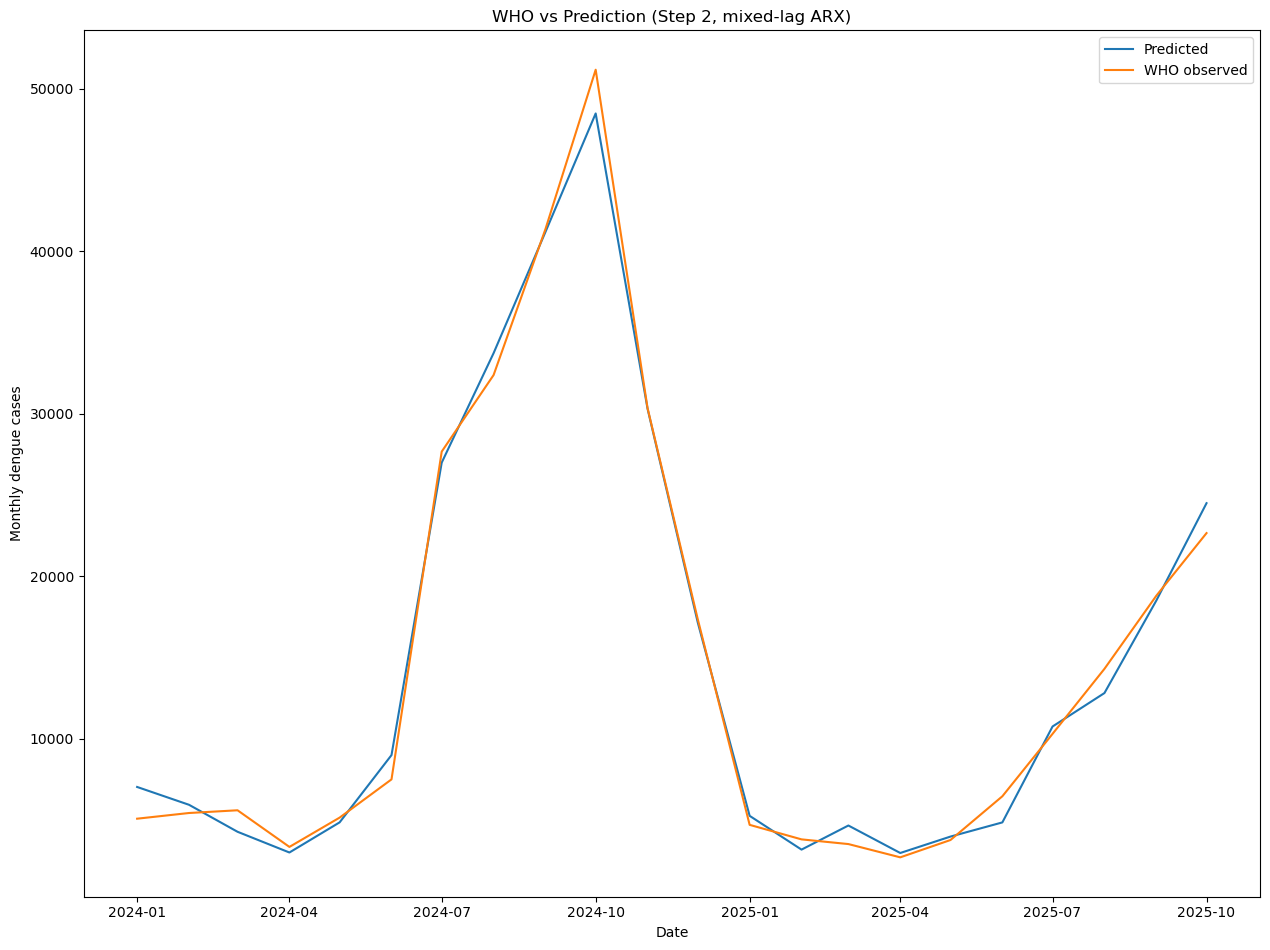

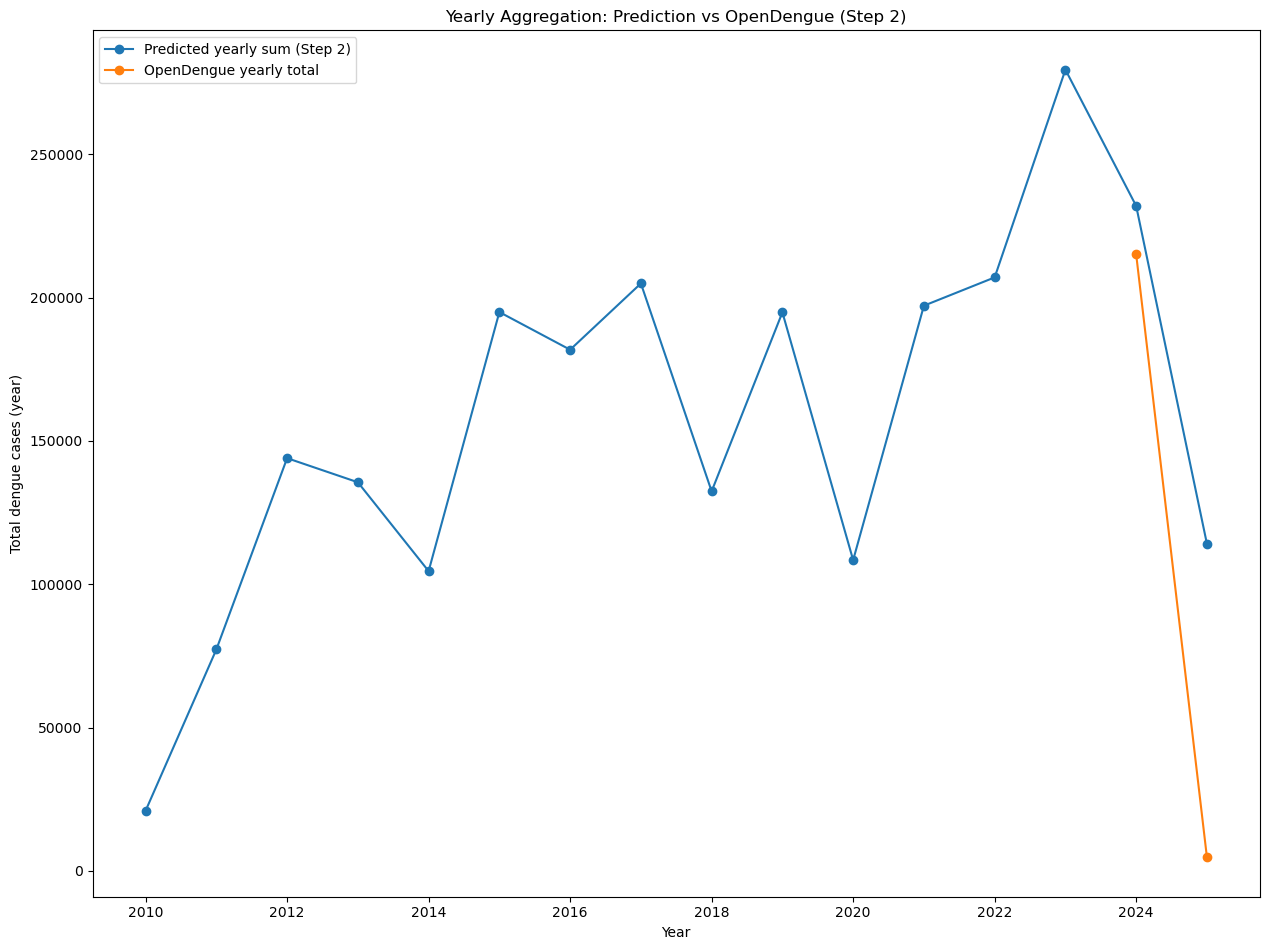

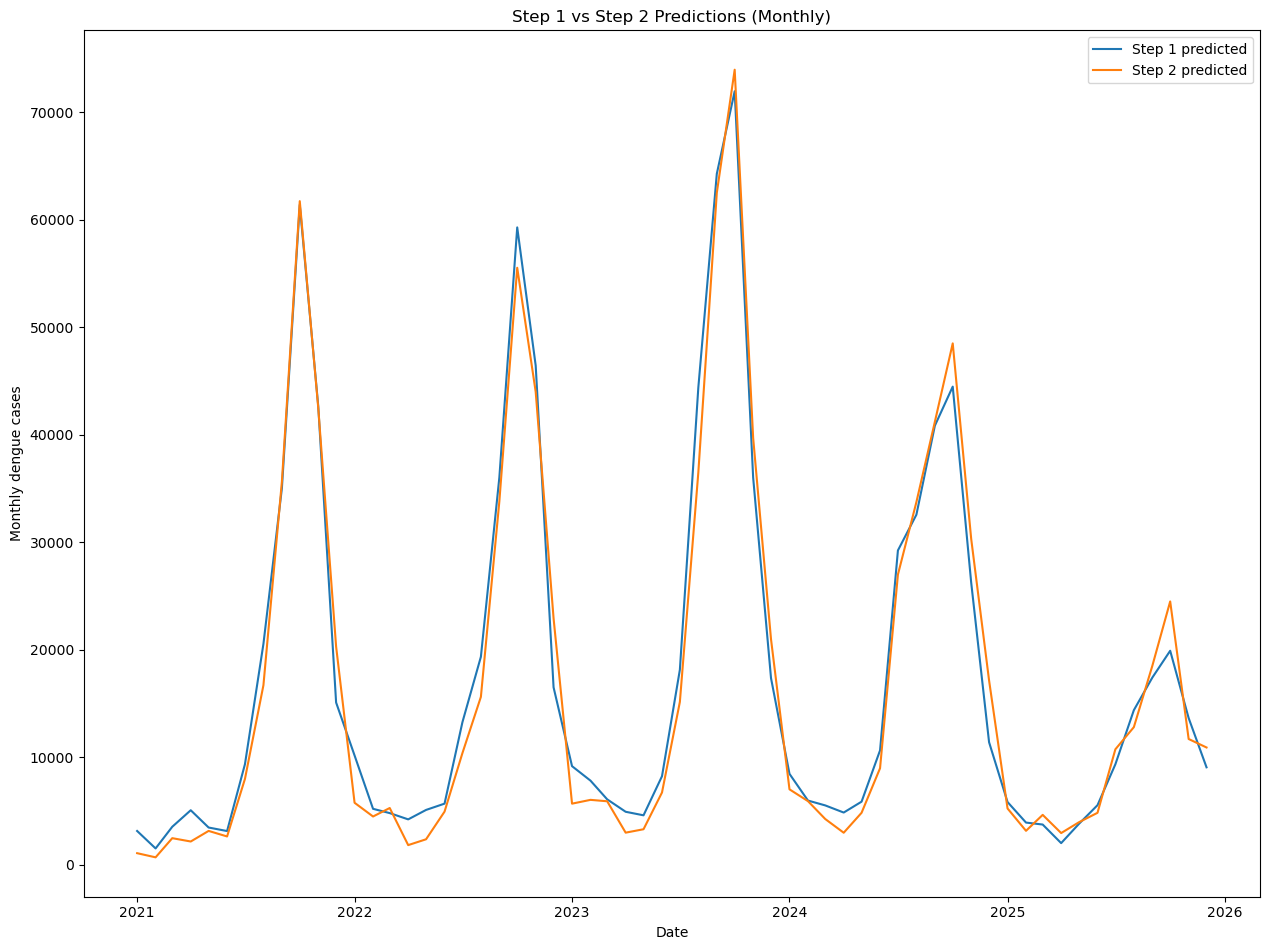

In [13]:
# Plots (also saved to outputs_step2/)
save_step2_plots(wide, nowcast, cfg)

## Notes
- If you see many missing features at the end (`n_features_missing` is large), it usually means some signals are not available for those months.
- The mixed-lag AR part avoids using median-imputed lagged WHO when WHO is missing by backfilling lags with Step 1 estimates.
